In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import shutil
import matplotlib.pyplot as plt
import pandas as pd

from DataObjects import DataLoader
from Architectures.SimpleCNN import SimpleCNN
from Architectures.OptimalCNN import OptimalCNN
from Architectures.StochasticDepthCNN import StochasticDepthCNN

from typing import Optional, Tuple

from utils import save_model, load_model


In [2]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                num_epochs: int = 10, lr: float = 0.001,
                device: torch.device = None) -> None:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion: nn.Module = nn.CrossEntropyLoss()
    optimizer: torch.optim.Optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss: float = 0.0
        train_correct: int = 0
        total_train: int = 0

        for batch in train_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        model.eval()
        val_loss: float = 0.0
        val_correct: int = 0
        total_val: int = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch.data.to(device)
                labels = batch.labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = val_correct / total_val

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_train_loss:.4f}, Train acc: {train_acc:.4f} | Val loss: {avg_val_loss:.4f}, Val acc: {val_acc:.4f}")

def infer(model: nn.Module, data_loader: DataLoader,
          device: torch.device = None) -> list:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions: list = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch.data.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().tolist())

    return predictions


def evaluate(model: nn.Module,
             test_loader: Optional[DataLoader] = None,
             device: Optional[torch.device] = None) -> Tuple[float, float]:

    if test_loader is None:
        test_dir = os.path.join("Data", "Data_converted", "test")
        test_loader = DataLoader(test_dir, batch_size=64, shuffle=True)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    model.eval()

    test_loss = 0.0
    test_correct = 0
    total_test = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels).item()
            total_test += labels.size(0)

    avg_test_loss = test_loss / total_test
    test_acc = test_correct / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return avg_test_loss, test_acc

In [3]:
def train_model_tune(config, num_epochs=10, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(config["train_dir"], batch_size=config["batch_size"], shuffle=True, max_per_class=150)
    val_loader = DataLoader(config["val_dir"], batch_size=config["batch_size"], shuffle=False, max_per_class=150)

    # Instantiate the model dynamically
    model = OptimalCNN(num_classes=10, dropout_chance=config["dropout"]).to(device)

    # Loss function & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["l2_lambda"])

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for batch in train_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch.data.to(device)
                labels = batch.labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = val_correct / total_val

        # Log to Ray Tune
        tune.report({"accuracy": val_acc, "loss": avg_val_loss })

In [4]:
@ray.remote
def setup_worker():
    """Ensure each Ray worker has access to the dataset."""
    worker_data_path = os.path.join(os.getcwd(), "worker_data")

    if not os.path.exists(worker_data_path):
        os.makedirs(worker_data_path)

    # Copy dataset if it doesn’t already exist
    source_data_path = os.path.abspath("Data/Data_converted")
    if not os.path.exists(os.path.join(worker_data_path, "Data_converted")):
        shutil.copytree(source_data_path, os.path.join(worker_data_path, "Data_converted"))

    return f"Worker setup complete: {worker_data_path}"

In [5]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32, 64]),
    "l2_lambda": 0.0,
    "dropout": 0.0,
    "train_dir": os.path.abspath("Data/Data_converted/train"),
    "val_dir": os.path.abspath("Data/Data_converted/valid")
}
scheduler = ASHAScheduler(metric="accuracy",
                          mode="max",
                          max_t=10,
                          grace_period=2,
                          reduction_factor=2)

In [6]:
test_dir = os.path.abspath("Data/Data_converted/test")
test_loader = DataLoader(test_dir, batch_size=64, shuffle=False)

In [7]:
ray.init(ignore_reinit_error=True)
# Run this before training
ray.get(setup_worker.remote())
# Launch hyperparameter search
tuner = tune.run(
    tune.with_parameters(train_model_tune),
    config=config,
    num_samples=10,  # Number of trials
    scheduler=scheduler
)

# Get the best configuration
best_trial = tuner.get_best_trial("accuracy", mode="max", scope="all")
best_config = best_trial.config
print("Best hyperparameters:", best_config)

2025-03-24 12:05:11,680	INFO worker.py:1852 -- Started a local Ray instance.
2025-03-24 12:05:12,359	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_model_tune pid=44402) *** SIGSEGV received at time=1742814377 on cpu 5 ***
(train_model_tune pid=44402) PC: @     0x7f0b64b38f0e  (unknown)  ray::gcs::TaskInfoAccessor::AsyncAddTaskEventData()
(train_model_tune pid=44402)     @     0x7f0b66445330       3408  (unknown)
(train_model_tune pid=44402)     @     0x7f0b64a17615       1392  ray::core::worker::TaskEventBufferImpl::FlushEvents()
(train_model_tune pid=44402)     @     0x7f0b6499dabc       1488  ray::core::CoreWorker::Disconnect()
(train_model_tune pid=44402)     @     0x7f0b6499dfed       1152  ray::core::CoreWorker::ForceExit()
(train_model_tune pid=44402)     @     0x7f0b6499e41f       1680  ray::core::CoreWorker::HandleKillActor()
(train_model_tune pid=44402)     @     0x7f0b649957a4        192  ray::rpc::ServerCallImpl<>::HandleRequestImpl()
(train_model_tune pid=44402)     @     0x7f0b64d6bf08       1168  EventTracker::RecordExecution()
(train_model_tune pid=44402)     @     0x7f0b64d66ede         48  std::_Function_h

Best hyperparameters: {'lr': 0.00023031011084705854, 'batch_size': 8, 'l2_lambda': 0.0, 'dropout': 0.0, 'train_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/Data/Data_converted/train', 'val_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/Data/Data_converted/valid'}


(train_model_tune pid=46120) *** SIGSEGV received at time=1742815179 on cpu 12 ***
(train_model_tune pid=46120) PC: @     0x769540338f0e  (unknown)  ray::gcs::TaskInfoAccessor::AsyncAddTaskEventData()
(train_model_tune pid=46120)     @     0x769541c45330       3408  (unknown)
(train_model_tune pid=46120)     @     0x769540217615       1392  ray::core::worker::TaskEventBufferImpl::FlushEvents()
(train_model_tune pid=46120)     @     0x76954019dabc       1488  ray::core::CoreWorker::Disconnect()
(train_model_tune pid=46120)     @     0x76954019dfed       1152  ray::core::CoreWorker::ForceExit()
(train_model_tune pid=46120)     @     0x76954019e41f       1680  ray::core::CoreWorker::HandleKillActor()
(train_model_tune pid=46120)     @     0x7695401957a4        192  ray::rpc::ServerCallImpl<>::HandleRequestImpl()
(train_model_tune pid=46120)     @     0x76954056bf08       1168  EventTracker::RecordExecution()
(train_model_tune pid=46120)     @     0x769540566ede         48  std::_Function_

In [8]:
best_model = OptimalCNN(num_classes=10)

# Setup directories and DataLoaders
train_dir = os.path.abspath("Data/Data_converted/train")
val_dir = os.path.abspath("Data/Data_converted/valid")

train_loader = DataLoader(train_dir, batch_size=best_config["batch_size"], shuffle=True, max_per_class=150)
val_loader = DataLoader(val_dir, batch_size=best_config["batch_size"], shuffle=False, max_per_class=150)

train_model(best_model, train_loader, val_loader, num_epochs=10, lr=best_config["lr"])

Epoch 1/10 - Train loss: 2.0304, Train acc: 0.2833 | Val loss: 1.8398, Val acc: 0.3433
Epoch 2/10 - Train loss: 1.7177, Train acc: 0.3847 | Val loss: 1.8817, Val acc: 0.3307
Epoch 3/10 - Train loss: 1.4423, Train acc: 0.4907 | Val loss: 1.6943, Val acc: 0.4067
Epoch 4/10 - Train loss: 1.1576, Train acc: 0.6040 | Val loss: 1.7762, Val acc: 0.4007
Epoch 5/10 - Train loss: 0.9192, Train acc: 0.7053 | Val loss: 1.6028, Val acc: 0.4600
Epoch 6/10 - Train loss: 0.6241, Train acc: 0.8140 | Val loss: 1.7862, Val acc: 0.4293
Epoch 7/10 - Train loss: 0.4378, Train acc: 0.8840 | Val loss: 1.6908, Val acc: 0.4553
Epoch 8/10 - Train loss: 0.2546, Train acc: 0.9513 | Val loss: 1.7107, Val acc: 0.4533
Epoch 9/10 - Train loss: 0.2026, Train acc: 0.9587 | Val loss: 1.7334, Val acc: 0.4647
Epoch 10/10 - Train loss: 0.1635, Train acc: 0.9667 | Val loss: 1.7338, Val acc: 0.4973


In [9]:
evaluate(best_model, test_loader)

Test Loss: 2.3227, Test Accuracy: 0.3827


(2.322665015856425, 0.38272222222222224)

In [10]:
best_batch = best_config.get('batch_size')
best_lr = best_config.get('lr')

config_batch = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": best_batch,
    "l2_lambda": 0.0,
    "dropout": 0.0,
    "train_dir": os.path.abspath("Data/Data_converted/train"),
    "val_dir": os.path.abspath("Data/Data_converted/valid")
}

config_lr = {
    "lr": best_lr,
    "batch_size": tune.choice([8, 16, 32, 64]),
    "l2_lambda": 0.0,
    "dropout": 0.0,
    "train_dir": os.path.abspath("Data/Data_converted/train"),
    "val_dir": os.path.abspath("Data/Data_converted/valid")
}

2025-03-24 12:10:27,043	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-24 12:15:22,966	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/piotr/ray_results/train_model_tune_2025-03-24_12-10-27' in 0.0039s.
2025-03-24 12:15:22,971	INFO tune.py:1041 -- Total run time: 295.93 seconds (295.91 seconds for the tuning loop).


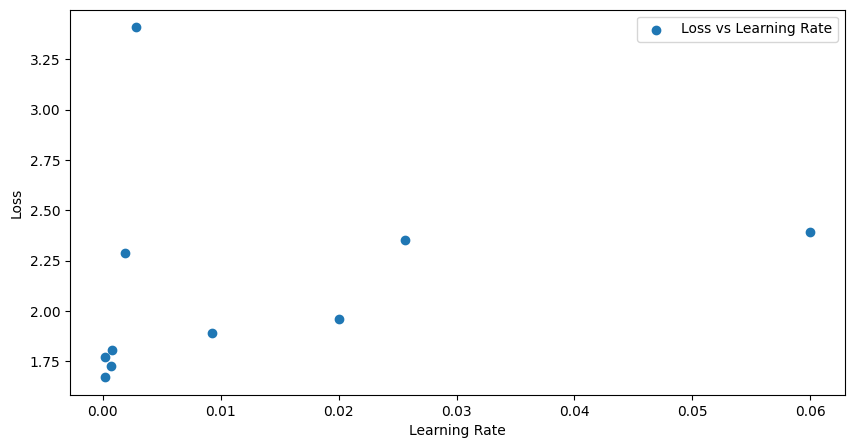

In [11]:
tuner = tune.run(
    tune.with_parameters(train_model_tune),
    config=config_batch,
    num_samples=10,  # Number of trials
    scheduler=scheduler
)

df = tuner.results_df
plt.figure(figsize=(10, 5))
plt.scatter(df["config/lr"], df["loss"], label="Loss vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.legend()
plt.show()

2025-03-24 12:15:23,108	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-24 12:20:27,901	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/piotr/ray_results/train_model_tune_2025-03-24_12-15-23' in 0.0040s.
2025-03-24 12:20:27,905	INFO tune.py:1041 -- Total run time: 304.80 seconds (304.78 seconds for the tuning loop).


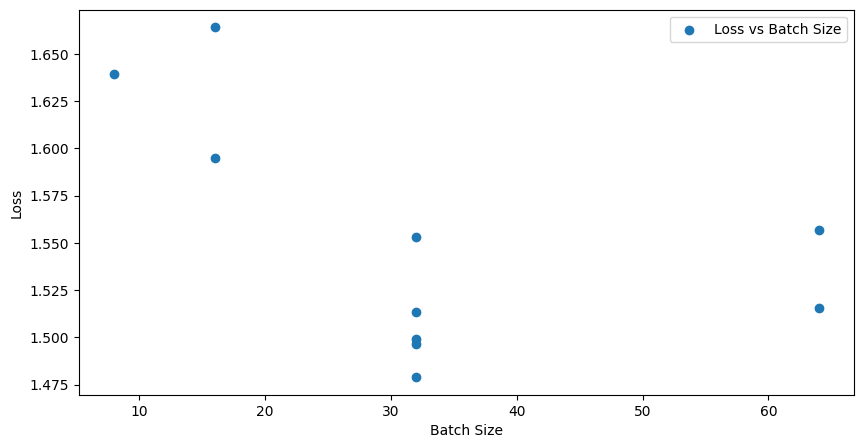

In [12]:
tuner = tune.run(
    tune.with_parameters(train_model_tune),
    config=config_lr,
    num_samples=10,  # Number of trials
    scheduler=scheduler
)

df = tuner.results_df
plt.figure(figsize=(10, 5))
plt.scatter(df["config/batch_size"], df["loss"], label="Loss vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
config_reg = {
    "lr": best_lr,
    "batch_size": best_batch,
    "l2_lambda": tune.uniform(1e-4, 1e-1),
    "dropout": tune.uniform(0, 0.5),
    "train_dir": os.path.abspath("Data/Data_converted/train"),
    "val_dir": os.path.abspath("Data/Data_converted/valid")
}

tuner = tune.run(
    tune.with_parameters(train_model_tune),
    config=config,
    num_samples=10,  # Number of trials
    scheduler=scheduler
)

# Get the best configuration
best_trial = tuner.get_best_trial("accuracy", mode="max", scope="all")
best_config = best_trial.config
print("Best hyperparameters:", best_config)

2025-03-24 12:20:28,029	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-24 12:23:52,053	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/piotr/ray_results/train_model_tune_2025-03-24_12-20-28' in 0.0043s.
2025-03-24 12:23:52,058	INFO tune.py:1041 -- Total run time: 204.03 seconds (204.01 seconds for the tuning loop).


Best hyperparameters: {'lr': 0.00018200858061700662, 'batch_size': 64, 'l2_lambda': 0.0, 'dropout': 0.0, 'train_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/Data/Data_converted/train', 'val_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/Data/Data_converted/valid'}
